# Preprocessing of Mutation Frequencies
This notebook is devoted to the preprocessing of TCGA mutation frequencies. I will derive a matrix, containing the mutation frequencies per samples (columns) and genes (rows).
This matrix will later be the feature matrix used by another notebook to form a hdf5 container.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mygene
import h5py
import os, sys
from sklearn.manifold import TSNE
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parameters
* `ULTRA_MUTATED_SAMPLES_THRESHOLD`: This value tells us how many mutations (CNAs + SNVs) a sample is allowed to have before we remove it. The reason behind this filtering step is that there are some samples with accumulated mutations that do not neccessarily contribute

In [2]:
ULTRA_MUTATED_SAMPLES_THRESHOLD = 1000

## Preprocessing SNVs
I downloaded one MAF file from TCGA. Those files have to be pre-processed, roughly following the data processing from HotNet2.
I decided to do the following steps:
1. Loading the MAF as `DataFrame`
2. Removing non-silent mutations (_step 2.ii in calling from HotNet2 preprocessing_)
3. Removing ultra-mutators (_step 1.i in filtering from HotNet2 preprocessing. Those are no longer present, though_)
4. Compute $Gene \times Sample$ matrix $S_c$ for each cancer type $c$

**I did not normalize the mutation frequency for the gene length**

In [3]:
trim_fun = lambda x: '-'.join(str(x).split('-')[:4]) # TCGA barcode including sample

def get_gene_sample_matrix(path, ultra_mutators):
    maf = pd.read_csv(path, compression='gzip', sep='\t', comment='#', header=0)
    non_silent = maf[maf.Variant_Classification != 'Silent'] # remove silent mutations
    print ("Removed {} (of {}) mutations because they are silent".format(maf.shape[0]-non_silent.shape[0],
                                                                         maf.shape[0]))
    non_silent.Tumor_Sample_Barcode = non_silent.Tumor_Sample_Barcode.map(trim_fun)

    # remove ultra-mutators
    ultra_mutators = pd.read_csv(ultra_mutators, header=None, names=['Tumor_IDs'])
    ultra_mutators.Tumor_IDs = ultra_mutators.Tumor_IDs.map(trim_fun)
    maf_no_ultra = non_silent[~non_silent.Tumor_Sample_Barcode.isin(ultra_mutators.Tumor_IDs)]
    print ("Left with {} SNVs after removing {} mutations in hyper-mutated samples".format(maf_no_ultra.shape[0], non_silent.shape[0]-maf_no_ultra.shape[0]))
    
    # compute gene x sample matrix
    gene_barcode_mat = maf_no_ultra.groupby(['Hugo_Symbol', 'Tumor_Sample_Barcode']).size().reset_index().rename(columns={0:'count'})
    assert ((gene_barcode_mat.pivot(index='Hugo_Symbol',
                                    columns='Tumor_Sample_Barcode',
                                    values='count'
                                   ).sum() == maf_no_ultra.groupby('Tumor_Sample_Barcode').count().Hugo_Symbol).all())
    assert ((gene_barcode_mat.pivot(index='Hugo_Symbol',
                                    columns='Tumor_Sample_Barcode',
                                    values='count'
                                   ).sum(axis=1) == maf_no_ultra.groupby('Hugo_Symbol').count().Tumor_Sample_Barcode).all())
    gene_sample_matrix = gene_barcode_mat.pivot(index='Hugo_Symbol', columns='Tumor_Sample_Barcode', values='count').replace(np.NaN, 0)
    
    return gene_sample_matrix

In [4]:
base_dir = '../../data/pancancer/TCGA/mutation/download_new/'
ultra_mutator_file = '../../data/pancancer/TCGA/mutation/ultramutated_tumor_ids'
all_matrices = []
ctypes = []
for dname in os.listdir(base_dir):
    ctype_dir = os.path.join(base_dir, dname)
    if os.path.isdir(ctype_dir):
        for maffile in os.listdir(ctype_dir):
            if maffile.endswith('.maf.gz'):
                gene_sample_matrix = get_gene_sample_matrix(os.path.join(ctype_dir, maffile), ultra_mutators=ultra_mutator_file)
                all_matrices.append(gene_sample_matrix)
                ctype = maffile.split('.')[1]
                print ("Processed {} with {} samples".format(ctype, gene_sample_matrix.shape[1]))
                ctypes.append(ctype)

/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 11029 (of 64804) mutations because they are silent


/pkg/python-3.6.0-0/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Left with 50113 SNVs after removing 3662 mutations in hyper-mutated samples
Processed READ with 135 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87,88,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 44644 (of 213144) mutations because they are silent
Left with 168500 SNVs after removing 0 mutations in hyper-mutated samples
Processed STAD with 437 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87,88,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 41350 (of 208180) mutations because they are silent
Left with 164350 SNVs after removing 2480 mutations in hyper-mutated samples
Processed LUAD with 563 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (19,20,28,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 18759 (of 103405) mutations because they are silent
Left with 84646 SNVs after removing 0 mutations in hyper-mutated samples
Processed CESC with 289 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 7505 (of 45313) mutations because they are silent
Left with 37808 SNVs after removing 0 mutations in hyper-mutated samples
Processed ESCA with 184 samples
Removed 150337 (of 886377) mutations because they are silent
Left with 595030 SNVs after removing 141010 mutations in hyper-mutated samples
Processed UCEC with 512 samples
Removed 22391 (of 120988) mutations because they are silent
Left with 95408 SNVs after removing 3189 mutations in hyper-mutated samples
Processed BRCA with 977 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (88,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 10010 (of 54238) mutations because they are silent
Left with 44228 SNVs after removing 0 mutations in hyper-mutated samples
Processed LIHC with 364 samples
Removed 4192 (of 23765) mutations because they are silent
Left with 19573 SNVs after removing 0 mutations in hyper-mutated samples
Processed KIRP with 281 samples
Removed 50029 (of 264786) mutations because they are silent
Left with 167053 SNVs after removing 47704 mutations in hyper-mutated samples
Processed COAD with 381 samples
Removed 37375 (of 181116) mutations because they are silent
Left with 137321 SNVs after removing 6420 mutations in hyper-mutated samples
Processed LUSC with 488 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (87,118) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 22272 (of 102309) mutations because they are silent
Left with 75872 SNVs after removing 4165 mutations in hyper-mutated samples
Processed HNSC with 504 samples


/pkg/python-3.6.0-0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (88,98) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Removed 1519 (of 10899) mutations because they are silent
Left with 9380 SNVs after removing 0 mutations in hyper-mutated samples
Processed THCA with 491 samples
Removed 29267 (of 134513) mutations because they are silent
Left with 103792 SNVs after removing 1454 mutations in hyper-mutated samples
Processed BLCA with 411 samples
Removed 4467 (of 26693) mutations because they are silent
Left with 22226 SNVs after removing 0 mutations in hyper-mutated samples
Processed KIRC with 336 samples
Removed 6620 (of 29286) mutations because they are silent
Left with 22666 SNVs after removing 0 mutations in hyper-mutated samples
Processed PRAD with 495 samples


In [5]:
print ("Samples with mutations per Cancer Type:")
for i in range(len(all_matrices)):
    print ("{}: {} Samples".format(ctypes[i], all_matrices[i].shape))

Samples with mutations per Cancer Type:
READ: (15181, 135) Samples
STAD: (18897, 437) Samples
LUAD: (18540, 563) Samples
CESC: (18445, 289) Samples
ESCA: (14161, 184) Samples
UCEC: (21117, 512) Samples
BRCA: (18291, 977) Samples
LIHC: (14984, 364) Samples
KIRP: (10503, 281) Samples
COAD: (19304, 381) Samples
LUSC: (18316, 488) Samples
HNSC: (16939, 504) Samples
THCA: (5814, 491) Samples
BLCA: (18066, 411) Samples
KIRC: (10985, 336) Samples
PRAD: (11114, 495) Samples


In [7]:
# get the big gene x sample matrix for all cancer types
whole_gene_sample_matrix = all_matrices[0].join(all_matrices[1:], how='outer').fillna(0)
np.save('../../data/pancancer/TCGA/mutation/gene_sample_snvs.npy', whole_gene_sample_matrix)
whole_gene_sample_matrix.shape

(21668, 6848)

In [8]:
# get the mean matrices
mean_mutations = []
for df in all_matrices:
    mean_mutations.append(df.mean(axis=1))
mean_mutation_matrix = pd.DataFrame(mean_mutations, index=ctypes).T
mean_mutation_matrix.fillna(0, inplace=True)
mean_mutation_matrix.head()

,READ,STAD,LUAD,CESC,ESCA,UCEC,BRCA,LIHC,KIRP,COAD,LUSC,HNSC,THCA,BLCA,KIRC,PRAD
A1BG,0.014815,0.018307,0.015986,0.010381,0.000000,0.054688,0.003071,0.008242,0.003559,0.028871,0.010246,0.015873,0.000000,0.019465,0.002976,0.002020
A1CF,0.014815,0.022883,0.028419,0.020761,0.000000,0.062500,0.009212,0.010989,0.000000,0.023622,0.043033,0.017857,0.000000,0.009732,0.008929,0.016162
A2M,0.081481,0.064073,0.046181,0.017301,0.021739,0.126953,0.010235,0.010989,0.010676,0.068241,0.040984,0.011905,0.002037,0.034063,0.014881,0.006061
A2ML1,0.059259,0.061785,0.042629,0.027682,0.005435,0.101562,0.011259,0.010989,0.003559,0.097113,0.040984,0.017857,0.000000,0.029197,0.005952,0.002020
A3GALT2,0.000000,0.011442,0.001776,0.006920,0.005435,0.001953,0.000000,0.000000,0.000000,0.013123,0.002049,0.000000,0.000000,0.002433,0.000000,0.000000


In [9]:
mean_mutation_matrix.to_csv('../../data/pancancer/TCGA/mutation/gene_ctype_snvs.tsv', sep='\t')

In [10]:
whole_gene_sample_matrix.columns = whole_gene_sample_matrix.columns.map(trim_fun)
whole_gene_sample_matrix.head()

,TCGA-AF-2687-01A,TCGA-AF-2690-01A,TCGA-AF-2693-01A,TCGA-AF-3911-01A,TCGA-AF-3913-01A,TCGA-AF-3914-01A,TCGA-AF-4110-01A,TCGA-AF-5654-01A,TCGA-AF-6136-01A,TCGA-AF-6655-01A,...,TCGA-ZG-A9LN-01A,TCGA-ZG-A9LS-01A,TCGA-ZG-A9LU-01A,TCGA-ZG-A9LY-01A,TCGA-ZG-A9LZ-01A,TCGA-ZG-A9M4-01A,TCGA-ZG-A9MC-01A,TCGA-ZG-A9N3-01A,TCGA-ZG-A9ND-01A,TCGA-ZG-A9NI-01A
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3GALT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing CNAs
This section loads the CNA mean matrix computed by `preprocess_cnas.ipynb` and incorporates that additional information into our model.
The CNAs are also preprocessed a little. This involves the following steps:
1. Load the CNA files
2. Remove ultra-mutated samples

In [11]:
# load CNAs
cna_sample_matrix = pd.read_csv('../../data/pancancer/TCGA/mutation/firehose_cnas_sample_20160128.tsv')
cna_sample_matrix.rename(columns={'Unnamed: 0':'Name'}, inplace=True)
cna_sample_matrix.set_index('Name', inplace=True)
cna_sample_matrix.columns = cna_sample_matrix.columns.map(trim_fun)

cna_mean_matrix = pd.read_csv('../../data/pancancer/TCGA/mutation/firehose_cnas_meancancertypes_20160128.tsv', sep='\t')
cna_mean_matrix.rename(columns={'Unnamed: 0':'Name'}, inplace=True)
cna_mean_matrix.set_index('Name', inplace=True)

cna_sample_matrix.head()

,TCGA-05-4244-01A,TCGA-05-4249-01A,TCGA-05-4250-01A,TCGA-05-4382-01A,TCGA-05-4384-01A,TCGA-05-4389-01A,TCGA-05-4390-01A,TCGA-05-4395-01A,TCGA-05-4396-01A,TCGA-05-4397-01A,...,TCGA-ZP-A9D1-01A,TCGA-ZP-A9D2-01A,TCGA-ZP-A9D4-01A,TCGA-ZQ-A9CR-01A,TCGA-ZR-A9CJ-01B,TCGA-ZS-A9CD-01A,TCGA-ZS-A9CE-01A,TCGA-ZS-A9CF-01A,TCGA-ZS-A9CG-01A,TCGA-ZX-AA5X-01A
Name,,,,,,,,,,,,,,,,,,,,,
7SK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2ML1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print ("Found {} samples in MAF files".format(whole_gene_sample_matrix.shape[1]))
print ("Found {} samples in CNA file".format(cna_sample_matrix.shape[1]))
samples_in_both = whole_gene_sample_matrix.columns.isin(cna_sample_matrix.columns).sum()
print ("Found {} samples in both, CNA and MAF".format(samples_in_both))

Found 6848 samples in MAF files
Found 7279 samples in CNA file
Found 6709 samples in both, CNA and MAF


In [13]:
# remove CNAs for ultra-mutated samples
ultra_mutators = pd.read_csv('../../data/pancancer/TCGA/mutation/ultramutated_tumor_ids', header=None, names=['Tumor_IDs'])
ultra_mutators.Tumor_IDs = ultra_mutators.Tumor_IDs.map(trim_fun)
cna_sample_matrix_no_ultra = cna_sample_matrix.loc[:, ~cna_sample_matrix.columns.isin(ultra_mutators.Tumor_IDs)]
print ("Removed {} CNA samples that belong to ultra-mutated samples".format(cna_sample_matrix.shape[1] - cna_sample_matrix_no_ultra.shape[1]))

Removed 68 CNA samples that belong to ultra-mutated samples


## Preprocess both together
As next step, let's **remove samples that have a very high number of mutations when adding CNAs and SNVs** and afterwords **remove all samples that only have CNAs but no SNVs.**

In [14]:
snvs_per_sample = whole_gene_sample_matrix.sum(axis=0)
mut_counts = cna_sample_matrix_no_ultra.sum(axis=0) + snvs_per_sample
mut_counts.fillna(0, inplace=True)
mut_counts = pd.DataFrame(mut_counts, columns=['num_mutations'])
mut_counts = mut_counts.groupby(mut_counts.index).sum() # sum duplicate samples
samples_with_many_mutations = mut_counts[mut_counts.num_mutations > ULTRA_MUTATED_SAMPLES_THRESHOLD]
print ("Removing {} samples because they have more than {} CNAs + SNVs".format(samples_with_many_mutations.shape[0], ULTRA_MUTATED_SAMPLES_THRESHOLD))

cna_sample_matrix_filtered = cna_sample_matrix_no_ultra.loc[:, ~cna_sample_matrix_no_ultra.columns.isin(samples_with_many_mutations.index)]
print ("--> {} samples with CNAs left".format(cna_sample_matrix_filtered.shape[1]))
snv_gene_sample_matrix = whole_gene_sample_matrix.loc[:,~whole_gene_sample_matrix.columns.isin(samples_with_many_mutations.index)]
print ("--> {} samples with SNVs left".format(snv_gene_sample_matrix.shape[1]))

Removing 307 samples because they have more than 1000 CNAs + SNVs
--> 6904 samples with CNAs left
--> 6541 samples with SNVs left


In [15]:
# remove CNAs that have no SNVs
final_cna_matrix = cna_sample_matrix_filtered.loc[:, cna_sample_matrix_filtered.columns.isin(snv_gene_sample_matrix.columns)]
print ("Removed {} samples with CNAs because they had no SNVs".format(cna_sample_matrix_filtered.shape[1] - final_cna_matrix.shape[1]))
print ("--> {} CNA samples left".format(final_cna_matrix.shape[1]))

Removed 502 samples with CNAs because they had no SNVs
--> 6402 CNA samples left


## Plot distributions
We now have obtained two gene-sample matrices $S_{SNV} \in \mathbb{R}^{N \times M_1}$ and $S_{CNA} \in \mathbb{R}^{N \times M_2}$, containing mutation frequencies for genes $N$ per sample ($M_1$ for SNVs and $M_2$ for CNAs).

Next, I want to plot some distributions and add the two together.

In [16]:
# put the two matrices together by appending them, replacing NAs with 0 and then summing the genes present in both, CNA and SNV
# I have to make sure that the columns of both matrices are in the same order. Do that by indexing
cna_mat_reindexed = final_cna_matrix.reindex(columns=snv_gene_sample_matrix.columns).dropna(axis=1)
assert ((snv_gene_sample_matrix.loc[:, snv_gene_sample_matrix.columns.isin(final_cna_matrix.columns)].columns == cna_mat_reindexed.columns).all())
cna_snv_sample_mat = snv_gene_sample_matrix.append(cna_mat_reindexed)
cna_snv_sample_mat.fillna(0, inplace=True)
cna_snv_sample_mat = cna_snv_sample_mat.groupby(cna_snv_sample_mat.index).sum()
cna_snv_sample_mat.shape, snv_gene_sample_matrix.index.isin(final_cna_matrix.index).sum()

((25826, 6541), 17788)

Text(0.5, 0, 'Mutation Frequency')

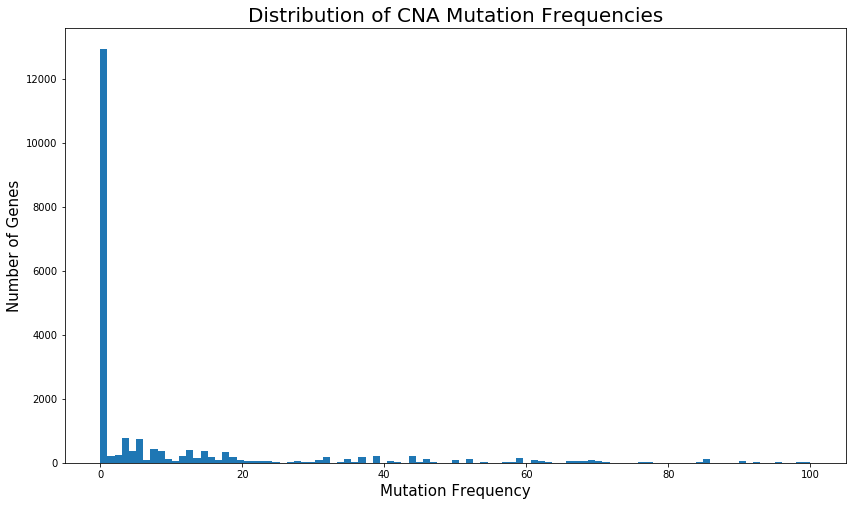

In [17]:
ax = final_cna_matrix.sum(axis=1).plot('hist', bins=np.linspace(0, 100, 100), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of CNA Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)

Text(0.5, 0, 'Number of Mutations')

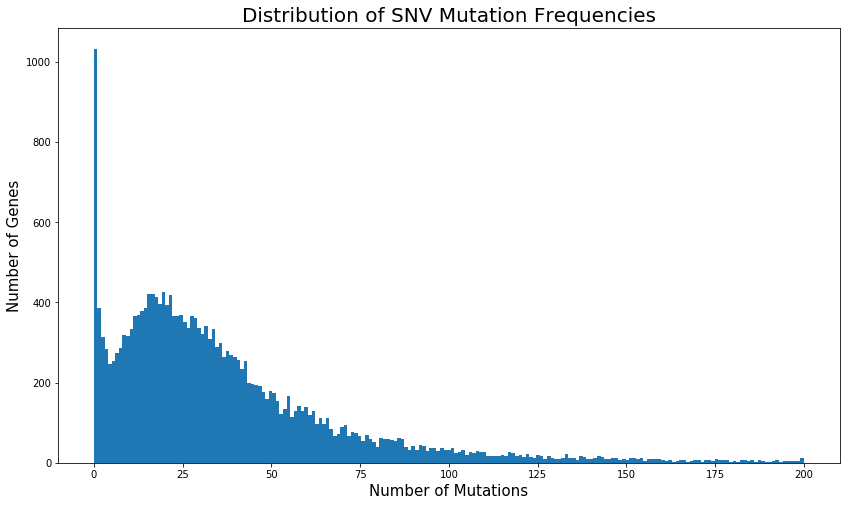

In [18]:
ax = snv_gene_sample_matrix.sum(axis=1).plot('hist', bins=np.linspace(0, 200, 200), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of SNV Mutation Frequencies', fontsize=20)
ax.set_xlabel('Number of Mutations', fontsize=15)

Number of genes in joint matrix: 25826


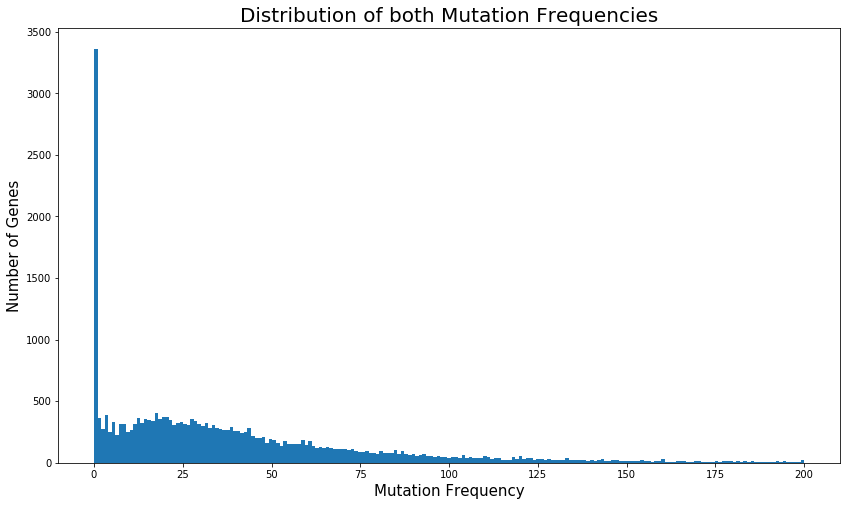

In [19]:
ax = cna_snv_sample_mat.sum(axis=1).plot('hist', bins=np.linspace(0, 200, 200), figsize=(14, 8))
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of both Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)
print ("Number of genes in joint matrix: {}".format(cna_snv_sample_mat.shape[0]))

In [20]:
final_matrix = cna_snv_sample_mat

## Convert Gene Names to Ensembl IDs
I finally have one big gene $\times$ sample matrix. I next want to get ensembl IDs for each of the genes to be able to compare with nodes in the networks afterwards.

In [22]:
# use mygene to get ensembl IDs from Hugo Symbols
mg = mygene.MyGeneInfo()
res = mg.querymany(final_matrix.index,
                   scopes='symbol',
                   fields='ensembl.gene, symbol',
                   species='human', returnall=True
                  )

# now, retrieve the names and IDs from a dictionary and put in DF
def get_name_and_id(x):
    ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
    name = x['symbol']
    query = x['query']
    if not name == query:
        print ("Error: ", name, query)
    return [ens_id, name]

ens_ids = [get_name_and_id(x) for x in res['out'] if 'ensembl' in x]
mapping = pd.DataFrame(ens_ids, columns=['Ensembl_ID', 'Name'])
mapping.set_index('Name', inplace=True)
mapping = mapping[~mapping.index.duplicated(keep='first')]

# join mutation frequencies with our derived mapping
mut_freq_sample = final_matrix.join(mapping)
print ("{} (of {}) genes had no mapping Ensembl ID".format(mut_freq_sample.Ensembl_ID.isnull().sum(),
                                                           mut_freq_sample.shape[0]))
mut_freq_sample.dropna(inplace=True) # remove unmapped genes simply

# make Ensembl ID the index and move Hugo Symbols to column
mut_freq_sample['Name'] = mut_freq_sample.index
mut_freq_sample.set_index('Ensembl_ID', inplace=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-25826...done.
Finished.
2629 input query terms found dup hits:
	[('AADACL2-AS1', 3), ('ABCC6P1', 2), ('ABHD17AP6', 2), ('ACE3P', 2), ('ACTBP12', 2), ('ACTR3BP2', 2)
2210 input query terms found no hit:
	['7SK', 'AAED1', 'AATK-AS1', 'AC000036.4', 'AC002519.6', 'AC003002.6', 'AC00395

In [23]:
mut_freq_sample.drop('Name', axis=1).sum().sum()

1197466.0

## Mean across cancer types & write to file
Finally, I want to compute the mean mutation frequency per cancer type and write the resulting $Gene \times Ctype$ matrix to a _csv_ file.

In [24]:
submitter_project_mapping = pd.read_json('../../data/pancancer/TCGA/mutation/download_new/cases_all_cancers.2018-11-26.json')
submitter_project_mapping.head()
submitter_project_mapping['Cancer_Type'] = [dict(i)['project_id'] for i in submitter_project_mapping.project]
submitter_project_mapping = submitter_project_mapping[['submitter_id', 'Cancer_Type']].set_index('submitter_id')
submitter_project_mapping.head()

trim_to_submitter = lambda x: '-'.join(str(x).split('-')[:3]) # TCGA barcode until patient
mut_freq_sample.columns = mut_freq_sample.columns.map(trim_to_submitter)
mut_freq_sample.head()

,TCGA-05-4244,TCGA-05-4249,TCGA-05-4250,TCGA-05-4384,TCGA-05-4389,TCGA-05-4390,TCGA-05-4395,TCGA-05-4398,TCGA-05-4402,TCGA-05-4403,...,TCGA-ZP-A9D2,TCGA-ZP-A9D4,TCGA-ZQ-A9CR,TCGA-ZR-A9CJ,TCGA-ZS-A9CD,TCGA-ZS-A9CE,TCGA-ZS-A9CF,TCGA-ZS-A9CG,TCGA-ZX-AA5X,Name
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A1BG
ENSG00000148584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A1CF
ENSG00000175899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A2M
ENSG00000166535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A2ML1
ENSG00000256069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A2MP1


In [25]:
# join with mapping and compute the mean across cancer types
no_names = mut_freq_sample.drop('Name', axis=1)
matrix_with_cancer_types = no_names.T.join(submitter_project_mapping)
mean_mut_freqs = matrix_with_cancer_types.groupby('Cancer_Type').mean().T
print (mean_mut_freqs.sum().sum())
mean_mut_freqs.columns = [i.split('-')[1] for i in mean_mut_freqs.columns]

# get back the gene names
assert((mean_mut_freqs.index == mut_freq_sample.index).all())
mean_mut_freqs['Name'] = mut_freq_sample.Name

# write to disk
mean_mut_freqs.to_csv('../../data/pancancer/TCGA/mutation/mutation_frequencies_mean.tsv', sep='\t')

mean_mut_freqs.head()

3093.872162415298


,BLCA,BRCA,CESC,COAD,ESCA,HNSC,KIRC,KIRP,LIHC,LUAD,LUSC,PRAD,READ,STAD,THCA,UCEC,Name
ENSG00000121410,0.017544,0.003102,0.007220,0.006135,0.000000,0.013917,0.002985,0.003597,0.008333,0.009346,0.008386,0.002028,0.015748,0.010444,0.000000,0.002445,A1BG
ENSG00000148584,0.010025,0.008273,0.014440,0.000000,0.000000,0.015905,0.008955,0.000000,0.008333,0.024299,0.033543,0.010142,0.007874,0.020888,0.000000,0.007335,A1CF
ENSG00000175899,0.030075,0.008273,0.010830,0.024540,0.022099,0.009940,0.014925,0.010791,0.011111,0.037383,0.041929,0.004057,0.031496,0.036554,0.002037,0.012225,A2M
ENSG00000166535,0.025063,0.010341,0.021661,0.042945,0.005525,0.015905,0.005970,0.003597,0.011111,0.031776,0.041929,0.002028,0.007874,0.036554,0.000000,0.014670,A2ML1
ENSG00000256069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A2MP1


## Plot information on the collected mutation frequencies

(-0.005, 0.05)

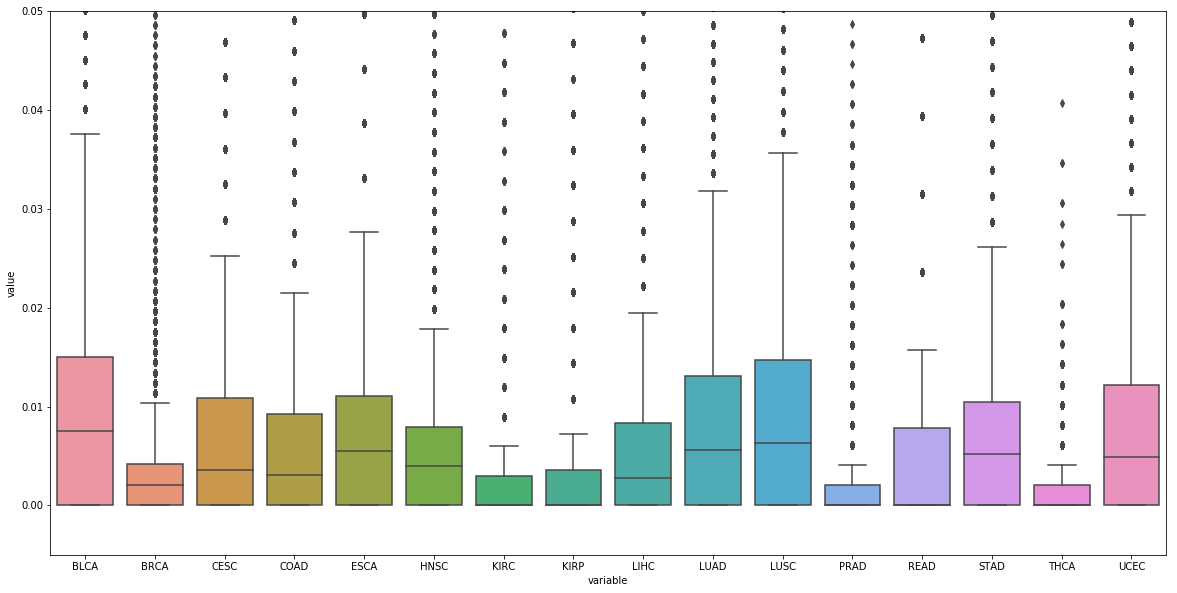

In [26]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(x='variable', y='value', data=pd.melt(mean_mut_freqs, id_vars='Name'))
plt.ylim([-0.005, 0.05])

Text(0.5, 0, 'Mutation Frequency')

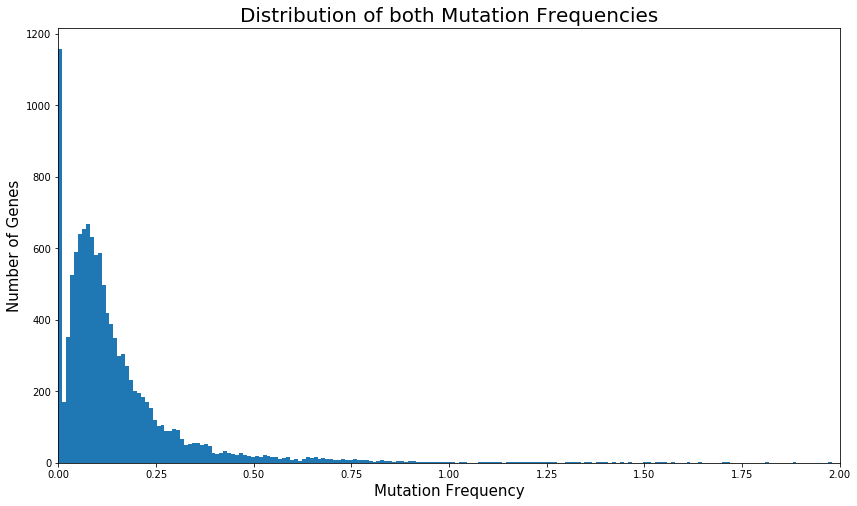

In [29]:
ax = features_df.sum(axis=1).plot(kind='hist', bins=np.linspace(0, 2, 200), figsize=(14, 8))
plt.xlim([0, 2])
ax.set_ylabel('Number of Genes', fontsize=15)
ax.set_title('Distribution of both Mutation Frequencies', fontsize=20)
ax.set_xlabel('Mutation Frequency', fontsize=15)

## Write a HDF container with the "raw" mutation frequencies
In the HDF5 container, I want to write the following:

* $Gene \times Sample$ matrix (for both, CNAs and SNVs)
* CNA matrix ($Gene \times Samples$)
* SNV matrix ($Gene \times Samples$)

In [30]:
fname = '../../data/pancancer/TCGA/mutation/mutation_frequencies_raw.h5'
snv_gene_sample_matrix.to_hdf(fname, 'snv_sample_matrix', mode='a')
final_cna_matrix.to_hdf(fname, 'cna_sample_matrix', mode='a')
cna_snv_sample_mat.to_hdf(fname, 'gene_sample_matrix', mode='a')
print ("Raw information written to {}".format(fname))

Raw information written to ../../data/pancancer/TCGA/mutation/mutation_frequencies_raw.h5


## T-SNE plot of the data

In [48]:
mut_sample_mat = matrix_with_cancer_types.set_index('Cancer_Type')
embedding = TSNE(n_components=2).fit_transform(mut_sample_mat.drop(['Cancer_Type'], axis=1, errors='ignore'))

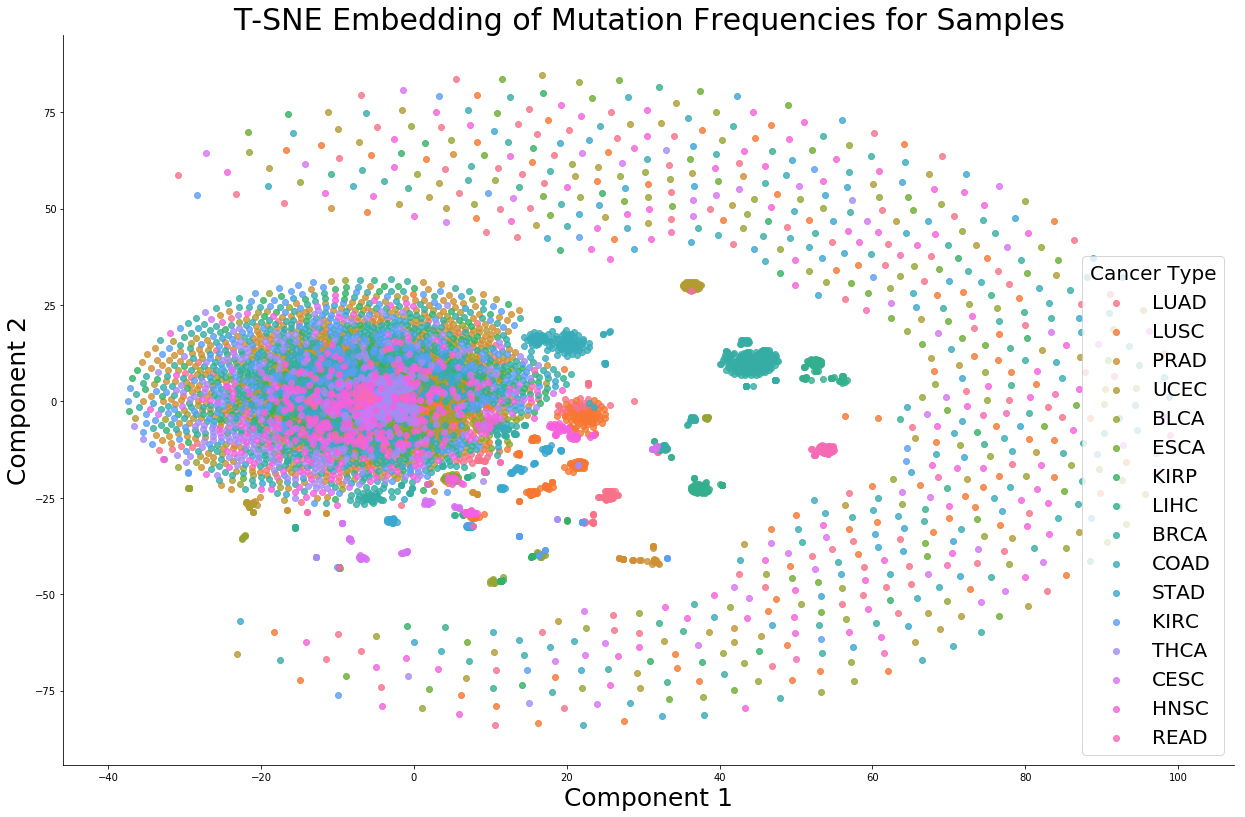

In [49]:
long = pd.DataFrame(embedding, columns=['pc1', 'pc2'], index=mut_sample_mat.index)
cancer_type = [i.split('-')[1] for i in mut_sample_mat.index]
long['cancertype'] = cancer_type
g = sns.lmplot(x='pc1', y='pc2', data=long, hue='cancertype', fit_reg=False, legend=False)
g.fig.set_size_inches(20, 12)
g.ax.set_xlabel('Component 1', fontsize=25)
g.ax.set_ylabel('Component 2', fontsize=25)
g.ax.legend(loc='lower right', fontsize=20, title='Cancer Type')
plt.setp(g.ax.get_legend().get_title(), fontsize=20)
plt.title('T-SNE Embedding of Mutation Frequencies for Samples', fontsize=30)
g.fig.savefig('../../data/pancancer/TCGA/mutation/tsne_tumortypes.png', dpi=300)